# Convolutional Variational Autoencoder Implementation on Burst Windows

In [166]:
from ipyfilechooser import FileChooser
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy.stats import linregress
import os

### Import data

In [136]:
fc = FileChooser('./')  # or use an absolute path if needed
fc.title = "<b>Select preprocessing parameter file</b>"
fc.filter_pattern = ['*.npz']  # Only show .par files
display(fc)

FileChooser(path='C:\Users\omgui\Desktop\BASUS', filename='', title='<b>Select preprocessing parameter file</b…

In [167]:
data = dict(np.load(fc.selected, allow_pickle=True))

In [168]:
windows = np.array(data['handlesA'].item()['burst_windows'])
labels = data['handlesA'].item()['species']
assert windows.shape[0] == labels.shape[0]
windows.shape

(861, 21)

In [169]:
X_raw = torch.tensor(windows, dtype=torch.float32)  # shape: (N, 21)
min_val = X_raw.min()
max_val = X_raw.max()

X = (X_raw - min_val) / (max_val - min_val)
X = X.unsqueeze(1)  # (N, 1, 21)
#X = torch.log1p(X)
if torch.cuda.is_available():
    X = X.cuda()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [170]:
X

tensor([[[9.2140e-05, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[2.4271e-03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          9.2166e-05, 1.8434e-03]],

        [[0.0000e+00, 0.0000e+00, 6.7622e-04,  ..., 0.0000e+00,
          0.0000e+00, 9.2512e-05]],

        ...,

        [[1.9133e-03, 7.4587e-04, 1.9134e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[1.9134e-03, 0.0000e+00, 1.3297e-03,  ..., 0.0000e+00,
          7.4598e-04, 0.0000e+00]],

        [[7.4645e-04, 0.0000e+00, 7.4646e-04,  ..., 1.6273e-04,
          0.0000e+00, 1.3302e-03]]])

## Convolutional VAE Architecture

In [171]:
class ConvVAE(nn.Module):
    def __init__(self, input_length = 21, latent_dim = 3):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1), #(B, 16, 21)
            nn.ReLU(),
            nn.MaxPool1d(2), #(B, 16, 10)
            nn.Conv1d(16, 32, kernel_size=3, padding=1), #(B, 32, 10)
            nn.ReLU(),
            nn.MaxPool1d(2), #(B, 32, 5)
            #nn.Flatten() #(B, 160)
        )
        self.fc_mu = nn.Linear(32*5, latent_dim)
        self.fc_logvar = nn.Linear(32*5, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 32*5)
        self.decoder= nn.Sequential(
            nn.Unflatten(1, (32, 5)), # (B, 32, 5)
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2), #(B, 16, 12)
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2), #(B, 1, 26)
            nn.ReLU(),
            nn.Conv1d(1, 1, kernel_size=6) # (B, 1, 21)
        )

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + std * torch.randn_like(std)
    
    def forward(self, x):
        enc = self.encoder(x)
        enc_flat = enc.view(x.size(0), -1)
        mu = self.fc_mu(enc_flat)
        logvar = self.fc_logvar(enc_flat)
        z = self.reparametrize(mu, logvar)
        z_dec = self.decoder_input(z)
        recon = self.decoder(z_dec)
        return recon, mu, logvar
    
def vae_loss(recon, x, mu, logvar, beta=0.001):
    recon_loss = F.mse_loss(recon, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta*kl_div

In [172]:
loader = DataLoader(TensorDataset(X), batch_size = 8)
model = ConvVAE(input_length=21, latent_dim=3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
num_epochs = 5

### Training Loop

In [173]:
for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        x_batch = batch[0].to(DEVICE)
        recon, mu, logvar = model(x_batch)
        loss = vae_loss(recon, x_batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(loader):.4f}")

Epoch 1 - Loss: 0.0383
Epoch 2 - Loss: 0.0058
Epoch 3 - Loss: 0.0031
Epoch 4 - Loss: 0.0016
Epoch 5 - Loss: 0.0013


In [174]:
model.eval()
latents = []

with torch.no_grad():
    for batch in loader:
        x_batch = batch[0].to(DEVICE)
        enc = model.encoder(x_batch)
        enc_flat = enc.view(x_batch.size(0), -1)
        mu = model.fc_mu(enc_flat)
        latents.append(mu.cpu().numpy())
        

latents = np.concatenate(latents, axis=0)

assert latents.shape[0] == len(labels)

#pca = PCA(n_components=3)
#z_pca = pca.fit_transform(latents)


fig = go.Figure(data=[go.Scatter3d(
    x=latents[:, 0],
    y=latents[:, 1],
    z=latents[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=labels,
        colorscale='viridis',
        opacity=0.8,
        colorbar=dict(title='Species')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Latent Space',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


fig = go.Figure(data=[go.Scatter3d(
    x=latents[:, 0][labels!=0],
    y=latents[:, 1][labels!=0],
    z=latents[:, 2][labels!=0],
    mode='markers',
    marker=dict(
        size=4,
        color=labels[labels!=0],
        colorscale='viridis',
        opacity=0.8,
        colorbar=dict(title='Species')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Latent Space',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()

fig = go.Figure(data=[go.Scatter3d(
    x=latents[:, 0][labels!=1],
    y=latents[:, 1][labels!=1],
    z=latents[:, 2][labels!=1],
    mode='markers',
    marker=dict(
        size=4,
        color=labels[labels!=1],
        colorscale='viridis',
        opacity=0.8,
        colorbar=dict(title='Species')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Latent Space',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


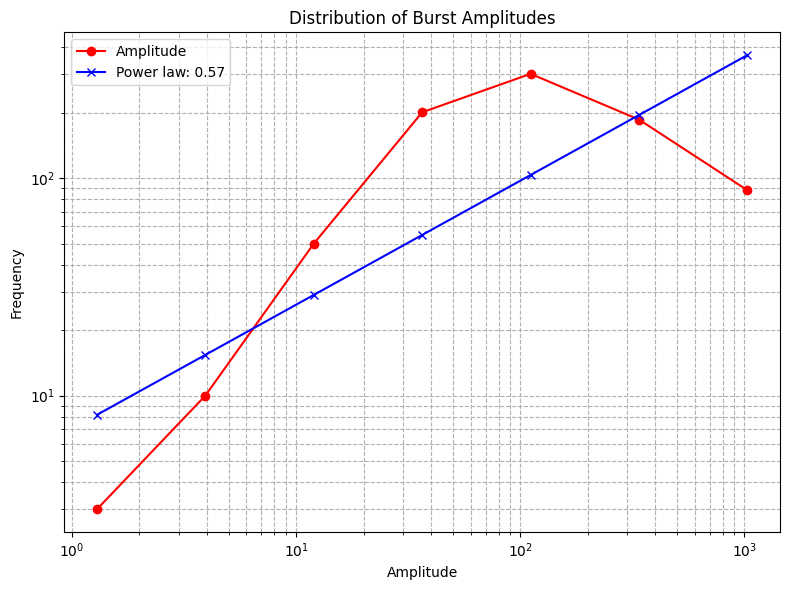

In [184]:
latent_dim = 3
num_samples = windows.shape[0]
z = torch.randn(num_samples, latent_dim).to(DEVICE)
with torch.no_grad():
    decoded = model.decoder(model.decoder_input(z)) #[num_samples, 1, 21]
    decoded = decoded.squeeze(1) #[num_samples, 21]
generated_unscaled = decoded * (max_val - min_val) + min_val
amplitudes = generated_unscaled.max(dim=1).values.cpu().numpy()

#generated_amplitudes = np.max(decoded, axis = 1)
#print(generated_amplitudes)
bins = np.logspace(np.log10(max(min(amplitudes), 1e-6)), np.log10(max(amplitudes)), 20)
hist, bin_edges = np.histogram(amplitudes, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

nonzero = hist > 0 & (bin_centers > 0)
x = bin_centers[nonzero]
y = hist[nonzero]

log_x = np.log10(x)
log_y = np.log10(y)
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
fit_y = 10**(slope * log_x + intercept)

plt.figure(figsize=(8, 6))
plt.loglog(x, y, '-ro', label='Amplitude')
plt.loglog(x, fit_y, '-bx', label=f'Power law: {slope:.2f}')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Distribution of Burst Amplitudes')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
#plt.savefig(os.path.join(f'{data['newdir'].item()}', "ampdist"))
plt.show()



In [185]:
model.eval()
with torch.no_grad():
    z_sample = torch.randn(1000, latent_dim).to(DEVICE)
    recon = model.decoder(model.decoder_input(z_sample)).squeeze(1).cpu().numpy()
    print(np.std(recon, axis=1))  # should not be all zero

[0.05338249 0.05173412 0.04859038 0.01045392 0.02531977 0.06962019
 0.02754345 0.0330334  0.0424683  0.01460524 0.0191315  0.06351254
 0.02224274 0.02310329 0.09223638 0.01370514 0.03237998 0.0460257
 0.01434576 0.01300114 0.04992604 0.04220045 0.07832409 0.01218281
 0.10703302 0.01387502 0.01997256 0.02555333 0.01069367 0.02981857
 0.03638002 0.01889136 0.03166639 0.04847716 0.05601783 0.01584275
 0.02404819 0.02453987 0.02552305 0.02833446 0.04492195 0.02234481
 0.00753305 0.01377142 0.01953527 0.01246282 0.07097235 0.05041915
 0.01310911 0.05603217 0.08626235 0.07127524 0.01548527 0.05014001
 0.03584792 0.04851954 0.01596689 0.03877033 0.01535381 0.07084961
 0.02454347 0.05299712 0.06196656 0.02375554 0.03655779 0.01892686
 0.02877666 0.02733181 0.0082232  0.01940254 0.07133524 0.08414544
 0.00913544 0.02334489 0.02320797 0.04350955 0.03836806 0.01278511
 0.12935959 0.16250761 0.02839118 0.12259287 0.1130034  0.02105268
 0.00868518 0.0101624  0.03101301 0.04629732 0.03259932 0.04020

In [163]:
model.eval()
latents = []
with torch.no_grad():
    for batch in loader:
        x_batch = batch[0].to(DEVICE)
        enc = model.encoder(x_batch)
        enc_flat = enc.view(x_batch.size(0), -1)
        mu = model.fc_mu(enc_flat)
        latents.append(mu.cpu().numpy())

latents = np.vstack(latents)
print("Latent mean:", np.mean(latents, axis=0))
print("Latent std:", np.std(latents, axis=0))


Latent mean: [-0.03487613 -0.03885567 -0.08877257]
Latent std: [0.01039921 0.19640358 0.27281585]


In [164]:
print(torch.mean(mu, dim=0))
print(torch.std(mu, dim=0))

tensor([-0.0327,  0.0553,  0.0422])
tensor([0.0005, 0.0182, 0.0260])


<Axes: >

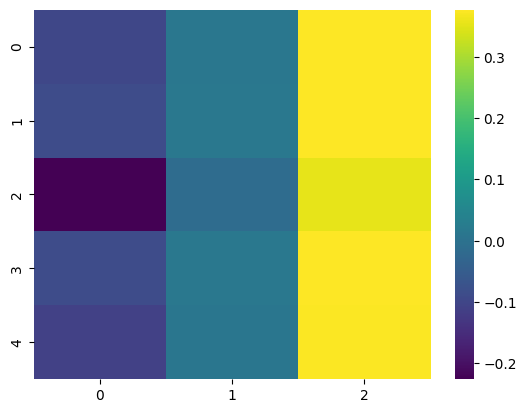

In [186]:
import seaborn as sns
sns.heatmap(mu.cpu().detach().numpy(), cmap="viridis")
